# Sentiment Analysis using BERT

BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.

### Import Libraries and Set the intial variables

In [3]:
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [6]:
df = pd.read_csv('../input/eurecom-aml-2023-challenge-3/train.csv')
df_test = pd.read_csv('../input/eurecom-aml-2023-challenge-3/test.csv')
df_test['sentiment'] = 0
df_test.head()

,textID,text,selected_text,sentiment
0,102f98e5e2,Happy Mother`s Day hahaha,Happy Mother`s Day,0
1,033b399113,"Sorry for the triple twitter post, was having ...","Sorry for the triple twitter post, was having ...",0
2,c125e29be2,thats much better than the flu syndrome!,thats much better,0
3,b91e2b0679,Aww I have a tummy ache,tummy ache,0
4,1a46141274,hey chocolate chips is good. i want a snack ...,good.,0


In [7]:
# Let's have a look at the data 
df.head()

,textID,text,selected_text,sentiment
0,28ac06f416,good luck with your auction,good luck with your auction,positive
1,92098cf9a7,Hmm..You can`t judge a book by looking at its ...,Hmm..You can`t judge a book by looking at its ...,neutral
2,7858ff28f2,"Hello, yourself. Enjoy London. Watch out for ...",They`re mental.,negative
3,b0c9c67f32,We can`t even call you from belgium sucks,m suck,negative
4,7b36e9e7a5,not so good mood..,not so good mood..,negative


We can see that the most relevant column for us is content and replyContent and the score as well.

In [8]:
# Let's check for missing values 
df.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

There are missing values in some of the columns but Content and score don't have a missing value. We can also look at the class balance. 

We will be alloting three classes:- 
1. Positive (Score: 4-5)
2. Neutral (Score: 3)
3. Negative (Score: 1-2)

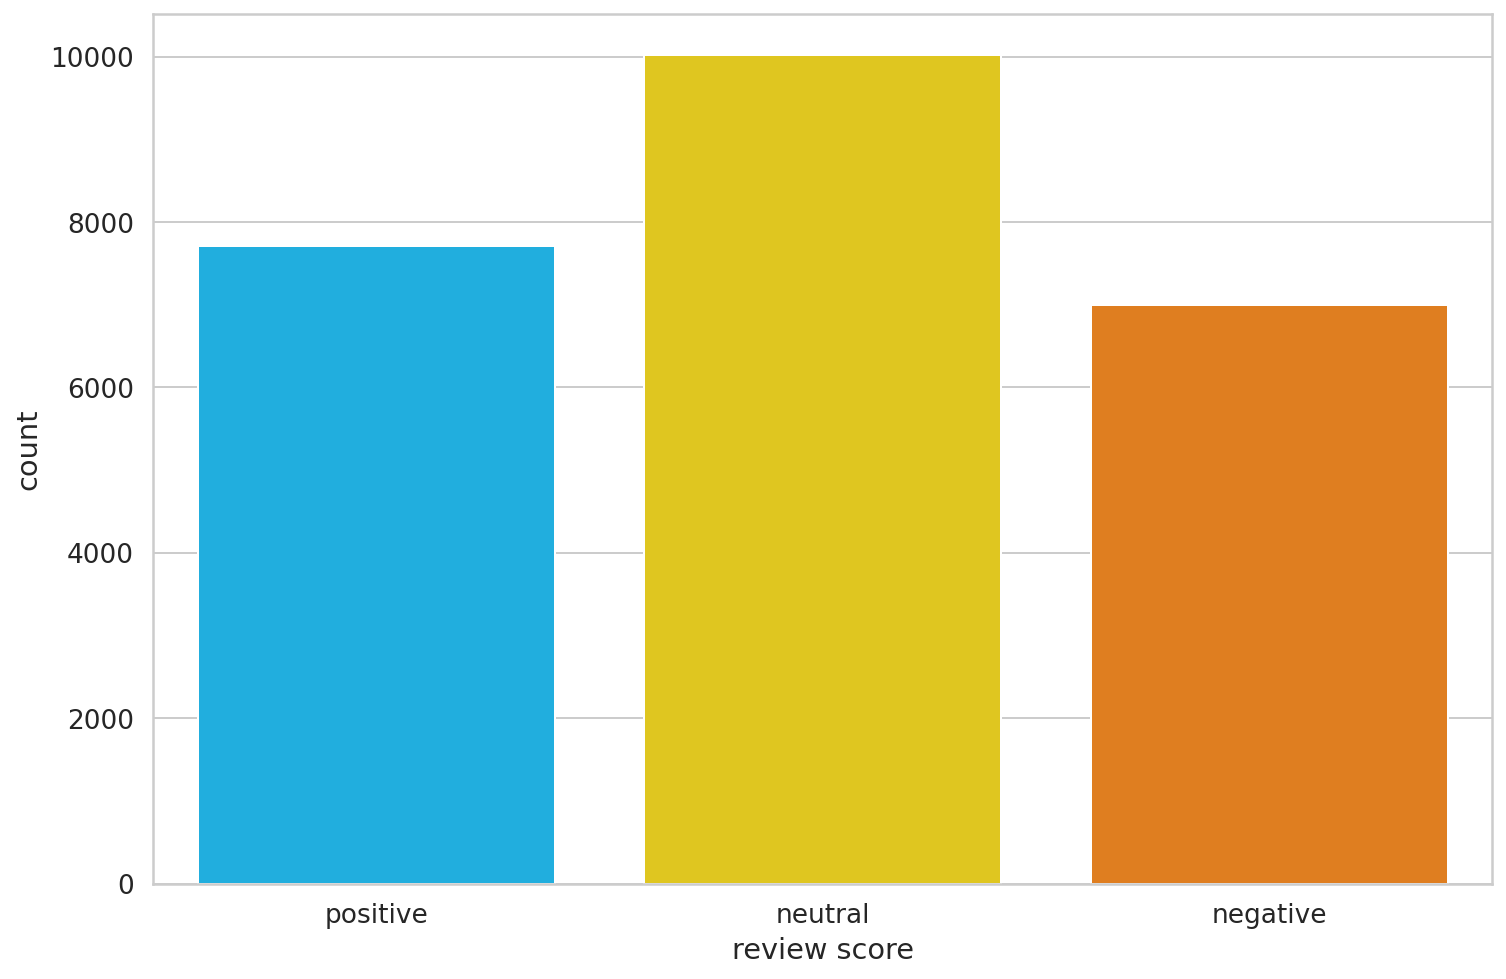

In [9]:
# Let's have a look at the class balance.
sns.countplot(df.sentiment)
plt.xlabel('review score');

We can see that we have more positive classes than negative and most of the neutral class.

In [10]:
# Function to convert score to sentiment
def to_sentiment(rating):
    
    
    # Convert to class
    if rating == 'negative':
        return 0
    elif rating == 'neutral':
        return 1
    elif rating == 'positive':
        return 2

# Apply to the dataset 
df['sentiment'] = df.sentiment.apply(to_sentiment)


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

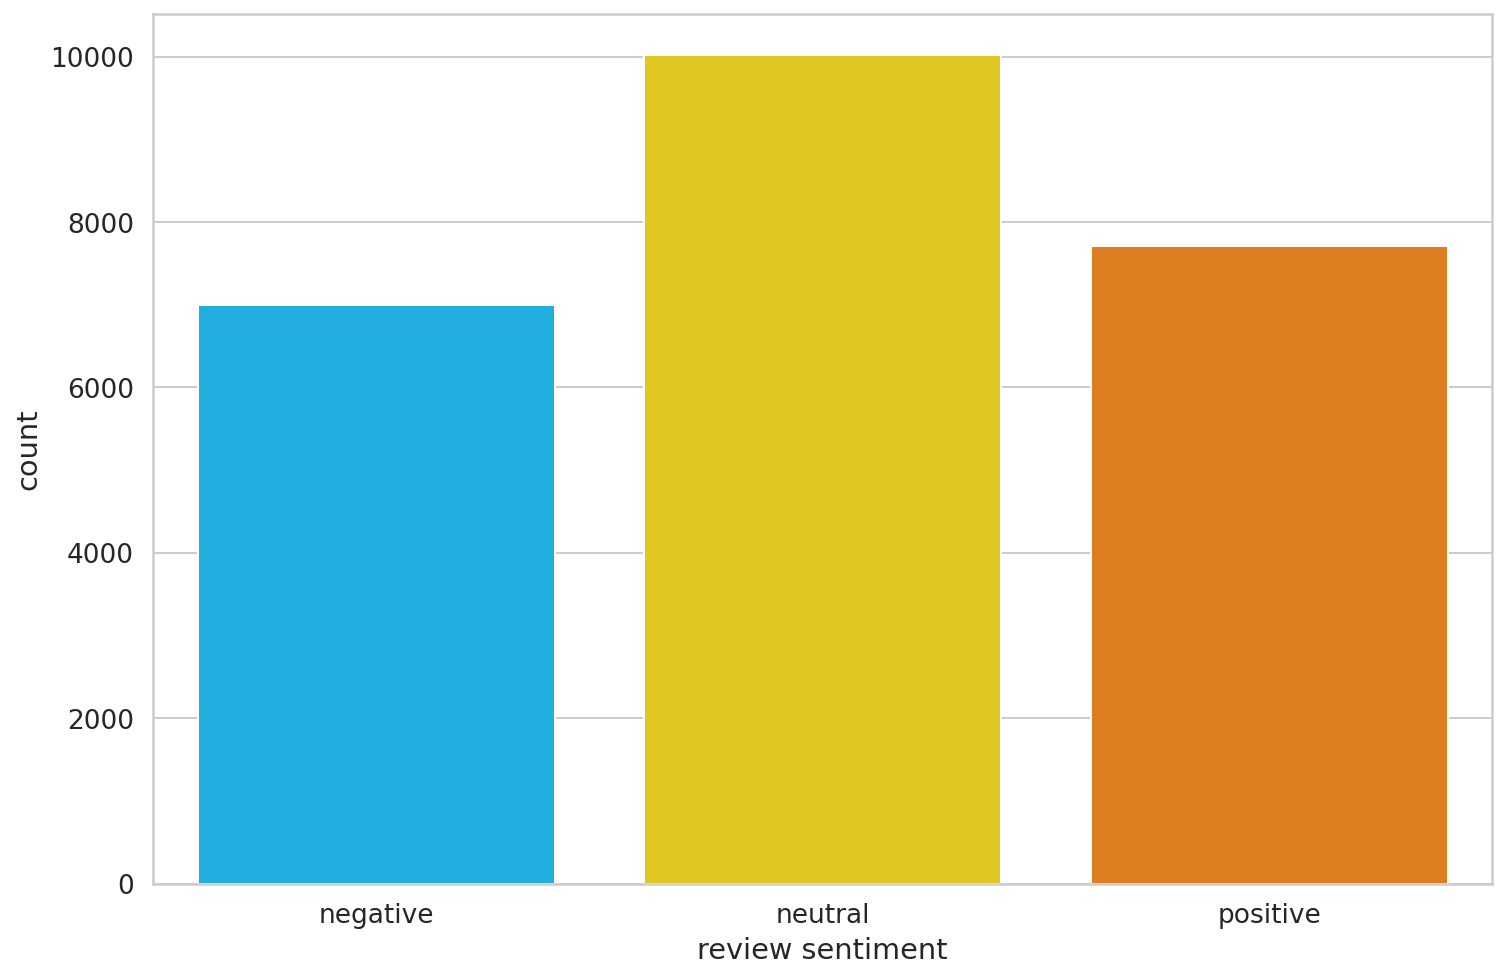

In [11]:
# Plot the distribution
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation. 

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word. 

In [12]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [13]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [14]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

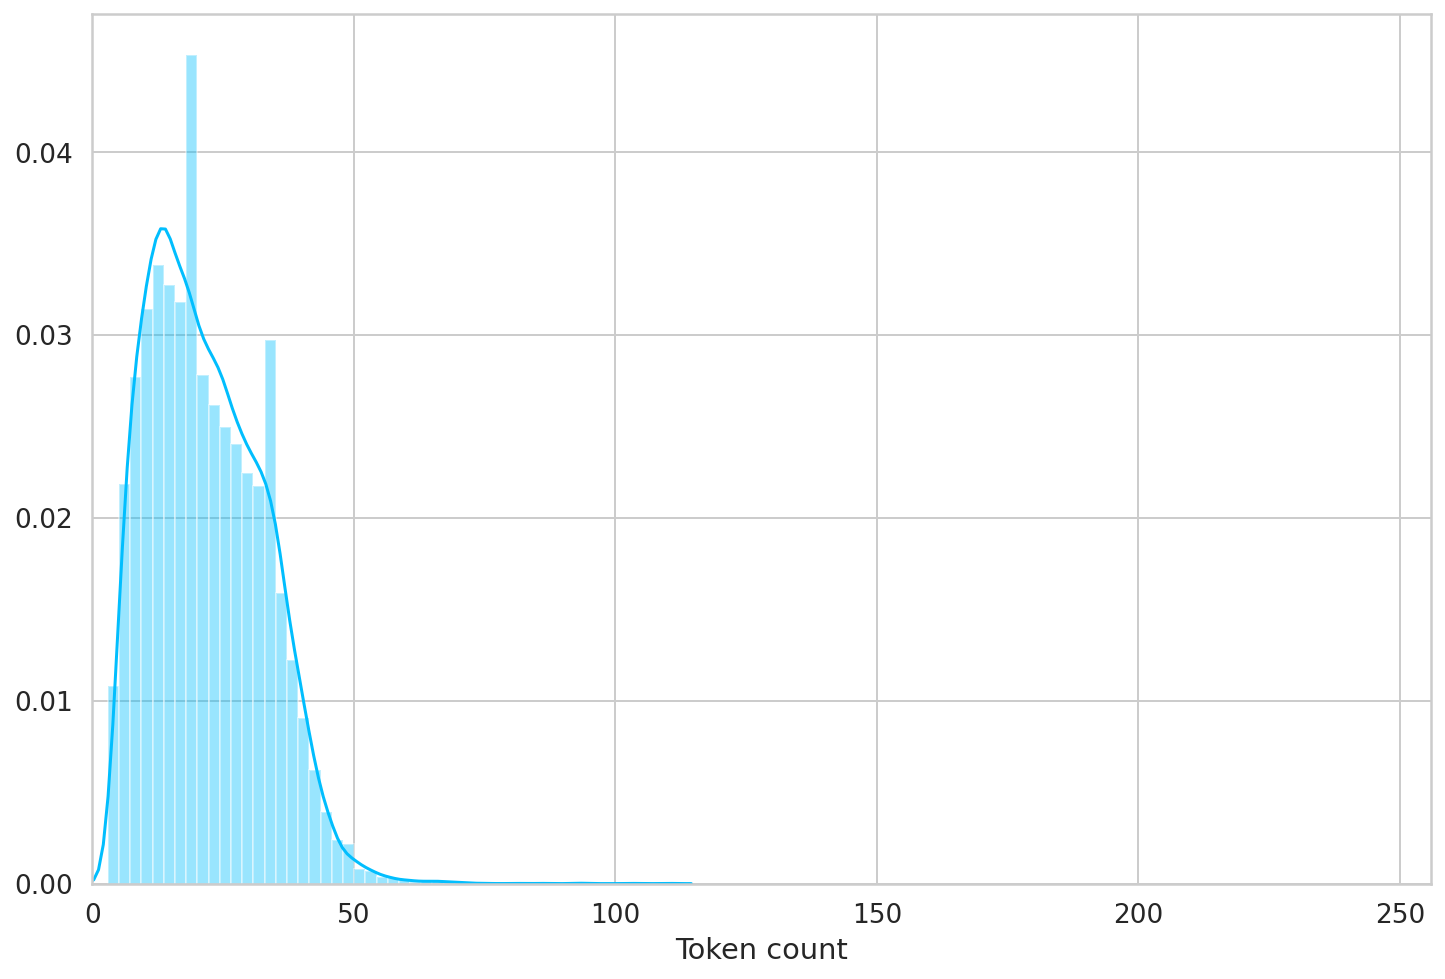

In [15]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160. 

In [16]:
MAX_LEN = max(token_lens)

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily. 

In [17]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [18]:
df_train, df_val = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
#df_train = df
print(df_train.shape, df_val.shape, df_test.shape)

(22258, 4) (2474, 4) (2748, 4)


Create a dataloader to release data in batches.

In [19]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )        
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [20]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [21]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 110])
torch.Size([16, 110])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [22]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [23]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [24]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [25]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [26]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [27]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [28]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [29]:
%%time
CUDA_LAUNCH_BLOCKING=1
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
    

Epoch 1/10
----------
Train loss 0.615432174972676 accuracy 0.745125348189415
Val   loss 0.5471703639914912 accuracy 0.7675828617623282

Epoch 2/10
----------
Train loss 0.43019259148063244 accuracy 0.8373618474256447
Val   loss 0.580833311042478 accuracy 0.7675828617623282

Epoch 3/10
----------
Train loss 0.3247502846235206 accuracy 0.8898373618474256
Val   loss 0.6608330680478004 accuracy 0.7744543249797897

Epoch 4/10
----------
Train loss 0.25038984406173453 accuracy 0.9233983286908077
Val   loss 0.8838014131592166 accuracy 0.7776879547291835

Epoch 5/10
----------
Train loss 0.2055257048941921 accuracy 0.9446041872585137
Val   loss 1.041540544792529 accuracy 0.7793047696038803

Epoch 6/10
----------
Train loss 0.16145121839701 accuracy 0.9593404618564111
Val   loss 1.1404767278401602 accuracy 0.7732417138237672

Epoch 7/10
----------
Train loss 0.13218290389855172 accuracy 0.9678767184832419
Val   loss 1.2917615022089692 accuracy 0.7732417138237672

Epoch 8/10
----------
Train lo

The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

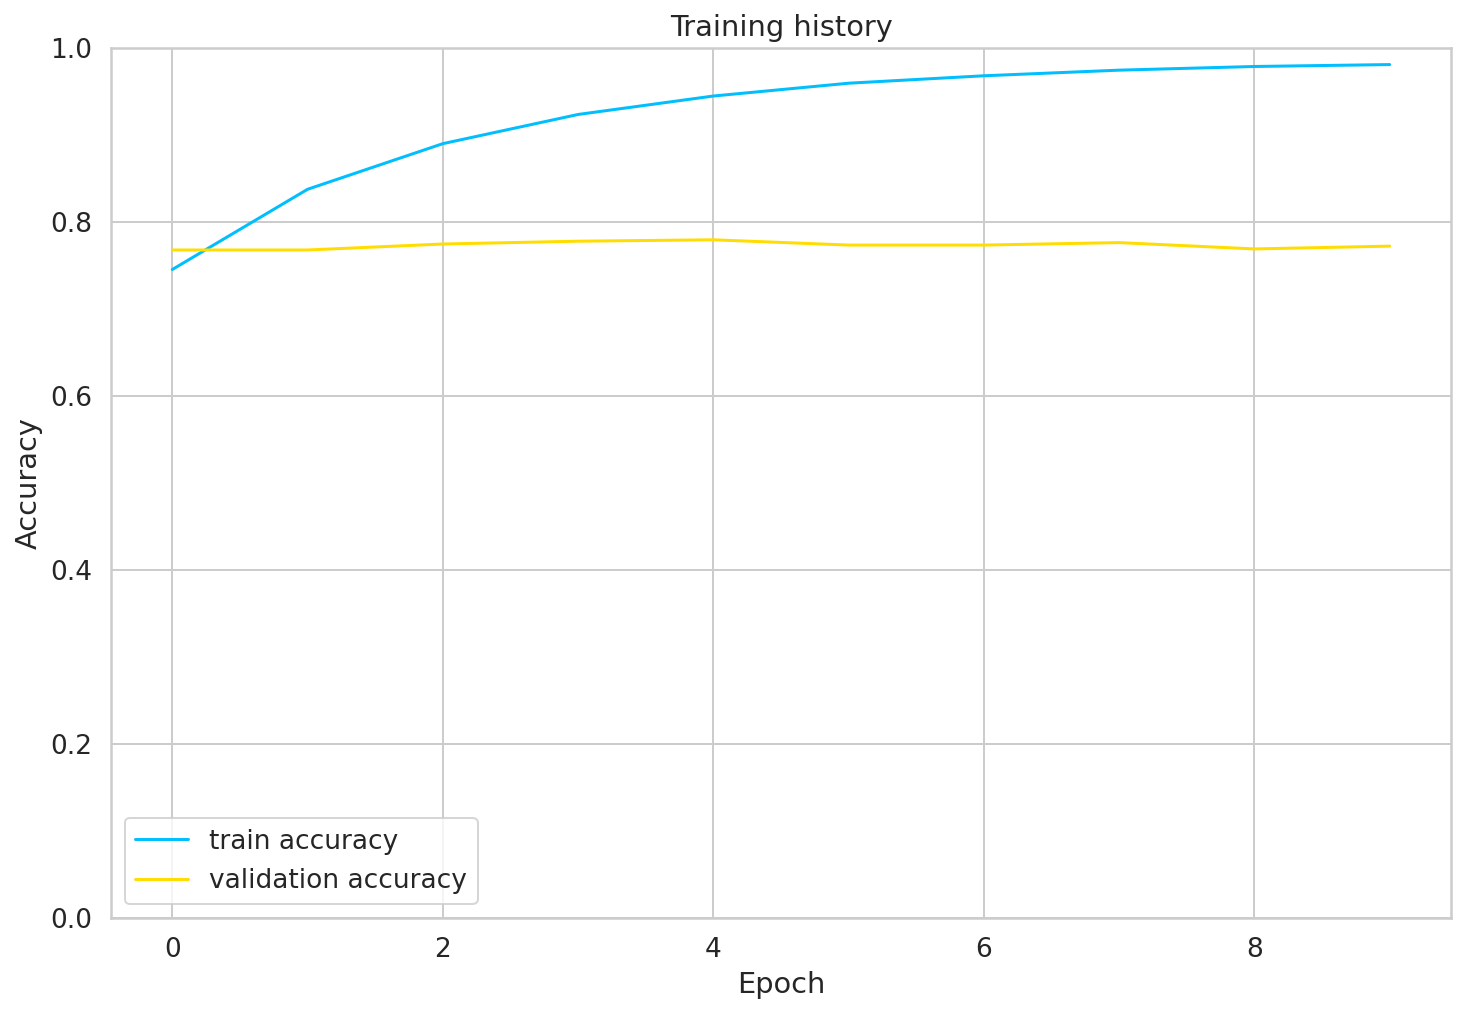

In [30]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Trying different batch sizes for the training process

Current batch size: 4
____________________
Epoch 1/10
----------
Train loss 0.7224591112913193 accuracy 0.7412166412076556
Val   loss 0.5899320945161755 accuracy 0.7849636216653193

Epoch 2/10
----------
Train loss 0.6072727175028652 accuracy 0.8320154551172612
Val   loss 0.7900902075510208 accuracy 0.7817299919159256

Epoch 3/10
----------
Train loss 0.4688749413045545 accuracy 0.8885793871866294
Val   loss 1.1432340898989626 accuracy 0.782538399353274

Epoch 4/10
----------
Train loss 0.350570555097535 accuracy 0.9273519633390241
Val   loss 1.3283152116267183 accuracy 0.7740501212611156

Epoch 5/10
----------
Train loss 0.24595107349095466 accuracy 0.9537245035492856
Val   loss 1.5517096571677034 accuracy 0.7675828617623282

Epoch 6/10
----------
Train loss 0.17117833151514836 accuracy 0.9692694761434091
Val   loss 1.738106317823807 accuracy 0.769199676637025

Epoch 7/10
----------
Train loss 0.11243710197260678 accuracy 0.979962260760176
Val   loss 1.8536756735993785 accuracy 0.7704

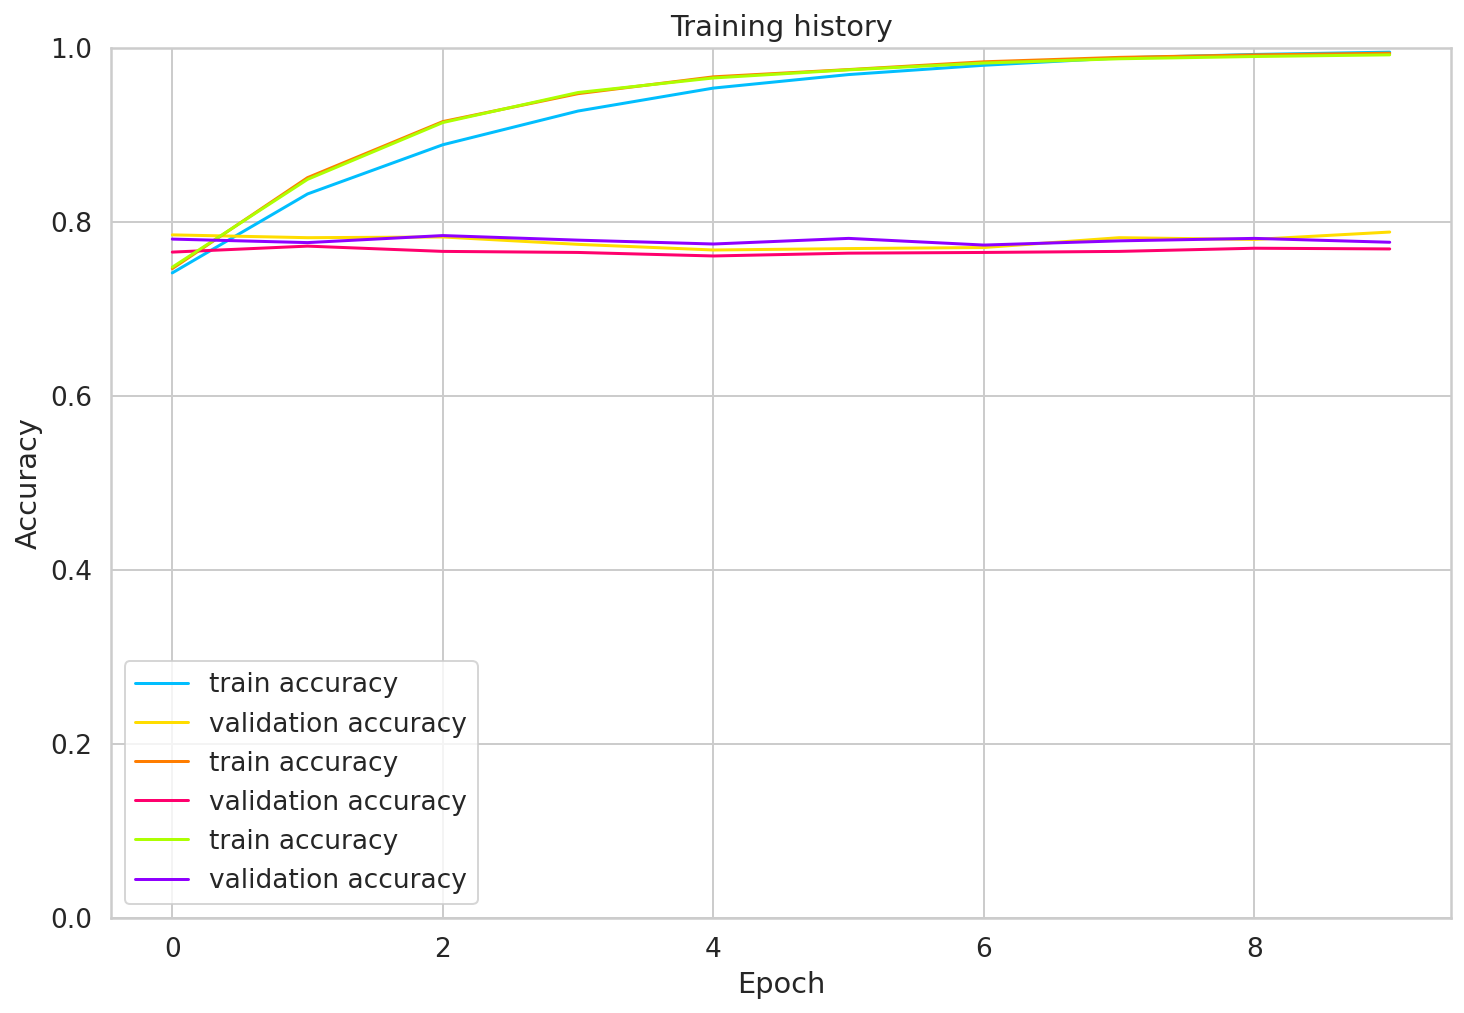

In [49]:
%%time
batch_sizes = [4, 16, 32]
# Number of iterations 
EPOCHS = 10


for bs in batch_sizes:
    print(f'Current batch size: {bs}')
    print('_' * 20)     
    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, bs)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, bs)
    
    # Instantiate the model and move to classifier
    model = SentimentClassifier(len(class_names))
    model = model.to(device)
    
    # Optimizer Adam 
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

    total_steps = len(train_data_loader) * EPOCHS

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Set the loss function 
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    #CUDA_LAUNCH_BLOCKING=1
    history = defaultdict(list)
    best_accuracy = 0
    
    for epoch in range(EPOCHS):

        # Show details 
        print(f"Epoch {epoch + 1}/{EPOCHS}")
        print("-" * 10)

        train_acc, train_loss = train_epoch(
            model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            scheduler,
            len(df_train)
        )

        print(f"Train loss {train_loss} accuracy {train_acc}")

        # Get model performance (accuracy and loss)
        val_acc, val_loss = eval_model(
            model,
            val_data_loader,
            loss_fn,
            device,
            len(df_val)
        )

        print(f"Val   loss {val_loss} accuracy {val_acc}")
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # If we beat prev performance
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
    # Plot training and validation accuracy
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')

    # Graph chars
    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1]);


### Model Evaluation

In [31]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.28820960698689957

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [32]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [33]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

In [39]:

_, test_predictions, _, _ = get_predictions(
    model,
    test_data_loader
)

submission_df = pd.DataFrame()
submission_df['textID'] = df_test['textID']
submission_df['sentiment'] = test_predictions -1
submission_df.to_csv('BERT.csv', index=False)
print("Done")

Done


## Predicting on raw text

In [35]:
review_text = "I love completing my todos! Best app ever!!!"

In [36]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [37]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
